In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from primesieve import *

from numba import njit, jit
from itertools import permutations

import random
import math

In [2]:
%%time

# parameters for setup, not important
SHINGLES = 2
PERMUTATIONS = 1 # how many permutations / hashes you want
TRESHOLD = 1
B = 1

df = pd.read_csv("news_articles_small.csv")
# df = pd.read_csv("news_articles_large.csv")

# Jaccard similarity
shingles = SHINGLES
shingles_dict = dict()

# convert articles into sets of shingles.
def apply_shingles(input):
    s = set()
    l = input.split(' ')
    for ind in range((len(l) - shingles + 1)):
        word = ' '.join(l[ind:ind+shingles])
        if word not in shingles_dict:
            shingles_dict[word] = len(shingles_dict)
        s.add(shingles_dict[word])
    return s
        
df["shingles"] = df["article"].apply(apply_shingles)
print(df.head())

# function to calculate jaccard similarity
def similarity(a, b):
    return (len(a & b) / len(a | b))

# calculate similarity between all documents, plot in histogram
similarities = list()
simdict = dict()
no_repeating = set()
for ind_i, i in enumerate(df["shingles"]):
    for ind_j, j in enumerate(df["shingles"]):
        if (ind_j, ind_i) in no_repeating:
            pass
        else:
            no_repeating.add((ind_i, ind_j))
            if ind_i != ind_j:
                sim = similarity(i, j)
                similarities.append(sim)
                if ind_i < ind_j:
                    simdict[(ind_i, ind_j)] = sim
                else:
                    simdict[(ind_j, ind_i)] = sim

hist = np.histogram(similarities, bins=10, range=(0, 1))



# set up parameters
all_shingles = np.array(list(shingles_dict.values()))
B = 1
SHINGLES = 2
PERMUTATIONS = 2 # how many permutations / hashes you want
TRESHOLD = 0.7


1.0
1.0
   News_ID                                            article
0        0  The Supreme Court in Johnnesberg on Friday pos...
1        1  The IG Metall union has decided not to spread ...
2        2  Malaysia said Friday it had no plans to overre...
3        3  South Korea is redoubling its efforts behind K...
4        4  The Philippine subsidiary of US telecommunicat...
   News_ID                                            article  \
0        0  The Supreme Court in Johnnesberg on Friday pos...   
1        1  The IG Metall union has decided not to spread ...   
2        2  Malaysia said Friday it had no plans to overre...   
3        3  South Korea is redoubling its efforts behind K...   
4        4  The Philippine subsidiary of US telecommunicat...   

                                            shingles  
0  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1  {512, 513, 514, 515, 516, 517, 518, 519, 520, ...  
2  {526, 527, 528, 529, 530, 531, 532, 533, 534, ...  
3  {1, 5,

In [3]:
# functionality for hashing, as explained in LSH.ipynb
class Hash:
    def __init__(self, a, b, p, len_shingles):
        self.a = a
        self.b = b
        self.p = p
        self.len_shingles = len_shingles

    def __call__(self, *args, **kwargs):
        return ((self.a * args[0] + self.b) % self.p) % self.len_shingles

def make_hashes(num_perm):
    p = n_primes(1,len(all_shingles))[0]
    hashes = []
    len_shingles = len(all_shingles)
    for i in range(num_perm):
        a = np.random.randint(1, p-1)
        b = np.random.randint(0, p-1)

        hashes.append(Hash(a,b,p,len_shingles))
    return hashes

def make_sign_matrix_hash(hashes, num_perm):
    sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)
    for doc_index, document in enumerate(df.shingles):
        for hash_index, hash in enumerate(hashes):
            min = float('inf')
            for shingle in document:
                tmp = hash(shingle)

                if tmp < min:
                    min = tmp
            sign_matrix[hash_index][doc_index] = min
    return sign_matrix

In [33]:
%%time
data = dict()
# iterate over B and PERMUTATIONS, PERMUTATIONS is the amount of hashes
for B in np.arange(1, 25):
    print(B)
    for PERMUTATIONS in np.arange(1, 100):
        # only use B, P pair P can be divided by B, to ensure full bands.
        if (PERMUTATIONS / B) == math.floor(PERMUTATIONS / B):
            print("\t", PERMUTATIONS)
            num_perm = PERMUTATIONS
            hashes = make_hashes(num_perm)

            info = dict()
            
            # calculate probability to find candidate pair at different tresholds
            info["catch rate"] = dict()
            for THRESHOLD in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                info["catch rate"][THRESHOLD] = 1 - np.power((1 - np.power(THRESHOLD, PERMUTATIONS / B)), B)


            # create the sign matrix
            sign_matrix = make_sign_matrix_hash(hashes, num_perm)

            # Locality-Sensitive Hashing

            bands = B

            # split the signature matrix in bands
            table = np.split(sign_matrix, bands)
            htable = [dict()] * bands
            candidate_pairs = set()

            # find all candidate pairs in this table
            for band_index, band in enumerate(table):
                # transposed since using rows for each document is easier than using columns
                for row_index, row in enumerate(band.T):
                    # if it already occurs in the table, add as pairs, otherwise insert in table
                    if row.tostring() in htable[band_index]:
                        for candidate in htable[band_index][row.tostring()]:
                            if row_index == candidate:
                                break
                            candidate_pairs.add((row_index, candidate))
                        htable[band_index][row.tostring()].add(row_index)
                    else:
                        htable[band_index][row.tostring()] = {row_index}

            # save how many candidate pairs are found
            info["amt cand pairs"] = len(candidate_pairs)

            # calculate accuracy of these parameters
            correctness = 0
            for pair in candidate_pairs:
                if pair[0] < pair[1]:
                    if simdict[(pair[0], pair[1])] >= TRESHOLD:
                        correctness += 1
                else:
                    if simdict[(pair[1], pair[0])] >= TRESHOLD:
                        correctness += 1

            correctness /= len(candidate_pairs)
            info["correctness"] = correctness

        
            # store all info in a data dictionary
            data[(B, PERMUTATIONS)] = info

1
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
	 54
	 55
	 56
	 57
	 58
	 59
	 60
	 61
	 62
	 63
	 64
	 65
	 66
	 67
	 68
	 69
	 70
	 71
	 72
	 73
	 74
	 75
	 76
	 77
	 78
	 79
	 80
	 81
	 82
	 83
	 84
	 85
	 86
	 87
	 88
	 89
	 90
	 91
	 92
	 93
	 94
	 95
	 96
	 97
	 98
	 99
2
	 2
	 4
	 6
	 8
	 10
	 12
	 14
	 16
	 18
	 20
	 22
	 24
	 26
	 28
	 30
	 32
	 34
	 36
	 38
	 40
	 42
	 44
	 46
	 48
	 50
	 52
	 54
	 56
	 58
	 60
	 62
	 64
	 66
	 68
	 70
	 72
	 74
	 76
	 78
	 80
	 82
	 84
	 86
	 88
	 90
	 92
	 94
	 96
	 98
3
	 3
	 6
	 9
	 12
	 15
	 18
	 21
	 24
	 27
	 30
	 33
	 36
	 39
	 42
	 45
	 48
	 51
	 54
	 57
	 60
	 63
	 66
	 69
	 72
	 75
	 78
	 81
	 84
	 87
	 90
	 93
	 96
	 99
4
	 4
	 8
	 12
	 16
	 20
	 24
	 28
	 32
	 36
	 40
	 44
	 48
	 52
	 56
	 60
	 64
	 68
	 72
	 76
	 80
	 84


--------  -----------  -----------  -----------  ------
(1, 1)    0.7          0.9          0.00837989     1074
(1, 2)    0.49         0.81         0.5              20
(1, 3)    0.343        0.729        1                10
(1, 4)    0.2401       0.6561       1                 9
(1, 5)    0.16807      0.59049      1                 9
(1, 6)    0.117649     0.531441     1                 9
(1, 7)    0.0823543    0.478297     1                10
(1, 8)    0.057648     0.430467     1                10
(1, 9)    0.0403536    0.38742      1                10
(1, 10)   0.0282475    0.348678     1                 9
(1, 11)   0.0197733    0.313811     1                 9
(1, 12)   0.0138413    0.28243      1                 9
(1, 13)   0.0096889    0.254187     1                 8
(1, 14)   0.00678223   0.228768     1                10
(1, 15)   0.00474756   0.205891     1                 7
(1, 16)   0.00332329   0.185302     1                 9
(1, 17)   0.00232631   0.166772     1           

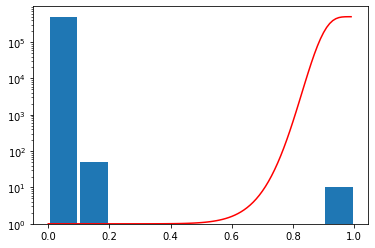

In [47]:
min = (float("inf"), #B
       float("inf"), #P
       float(0), #s = 0.7
       float(0) #s = 0.9
      )

# find optimal parameters
printable = list()
epsilon = 0.1
for i in data:
    # remove all elements with false positives or false negatives; also only keep with probability for 0.9 > 0.9
    if data[i]["correctness"] == 1 and data[i]["amt cand pairs"] == 10 and data[i]["catch rate"][0.9] > 0.9:
        # take the weighted sum to find optimal combination of (0.9 and 1-0.7)
        if np.sqrt(np.power(min[3], 2) + np.power(1 - min[2], 2)) + epsilon < np.sqrt(
            np.power(data[i]["catch rate"][0.9], 2) + np.power(1 - data[i]["catch rate"][0.7], 2)):
            min = (i[0], i[1], data[i]["catch rate"][0.7], data[i]["catch rate"][0.9])
    
    # save to output as table
    printable.append((i, data[i]["catch rate"][0.7], data[i]["catch rate"][0.9],
           data[i]["correctness"], data[i]["amt cand pairs"]))
    
# print table
from tabulate import tabulate
print(tabulate(printable))

# print optimal pair
print()
print(min)

# draw histogram
fig, ax = plt.subplots()
ax.bar(hist[1][:-1] + 0.05, hist[0], width=0.09)
ax.set_yscale("log")
x = [i/100 for i in range(0, 100)]
ax.plot(x, np.power(10, (1 - np.power((1 - np.power(x, min[1] / min[0])), min[0])) * np.log10(hist[0][0])), "r")
plt.ylim(bottom=1)
plt.show()

In [46]:
# export to csv
import csv

with open('gridsearch_output.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    for pair in printable:
        writer.writerow(pair)